## Lagrangian Neural Networks

Tutorial: https://colab.research.google.com/drive/1CSy-xfrnTX28p1difoTA8ulYw0zytJkq#scrollTo=9q6Od6KqZemA

In [1]:
import numpy as np
import seaborn as sns
from HenonHeiles import *
from tqdm import trange
import datetime

import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit
from jax.example_libraries import stax
from jax.example_libraries import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image


#Debugging nan values
jax.config.update("jax_debug_nans", True)

np.random.seed(33)

plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
colors = sns.color_palette([(0.6,0.8,.8), (1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0,0.4,1), (0.6,0.5,.9), (0.5,0.3,.5)])

In [2]:
def Lagrangian(q,q_dot,lam=1):
    x,y = q
    px,py = q_dot
    K = 0.5*(px**2+py**2)
    V = 0.5*(x**2+y**2)+lam*(x**2*y-1/3*y**3)
    L = K-V

    return L

In [3]:
def f_analytical(u,lam=1):
    if u.ndim ==1:
        x,y,px,py = u[0],u[1],u[2],u[3]
    else:
        x,y,px,py = u[:,0],u[:,1],u[:,2],u[:,3]
    f = jnp.stack([px,py,-x-2*lam*x*y,-y-lam*(x**2-y**2)])
  
    return f

### Deriving q_tt for Euler-Lagrange
$$
\begin{align}
\frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot q_j} &= \frac{\partial \mathcal{L}}{\partial q_j} & \text{write down the Euler-Lagrange equation} \quad (1)\\
\frac{d}{dt} \nabla_{\dot q} \mathcal{L} &= \nabla_{q} \mathcal{L} & \text{switch to vector notation} \quad (2)\\
(\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})\ddot q + (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L}) \dot q &= \nabla_q \mathcal{L} & \text{expand the time derivative }\frac{d}{dt} \quad (3)\\
\ddot q &= (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q] & \text{use a matrix inverse to solve for } \ddot q \quad (4)\\
\end{align}
$$

In [4]:
def Equation_of_motion(Lagrangian,u, t = None):
  q, q_t = jnp.split(u, 2,axis=-1)
  q_tt = (jnp.linalg.pinv(jax.hessian(Lagrangian, 1)(q, q_t)) @ (jax.grad(Lagrangian, 0)(q, q_t) - jax.jacobian(jax.jacobian(Lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t,q_tt],axis=-1)


def Solve_Lagrangian(Lagrangian, u0,**kwargs):
  @partial(jax.jit, backend='cpu')
  def f(u0):
    sol = odeint(partial(Equation_of_motion, Lagrangian),u0, **kwargs)
    return sol

  return f(u0)


In [5]:
# Henon-Heiles dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(u0, times):
  L = partial(Lagrangian)
  return Solve_Lagrangian(L, u0, t=times, rtol=1e-10, atol=1e-10)

# Henon-Heiles dynamics via analytical forces 
@partial(jax.jit, backend='cpu')
def solve_analytical(u0, times):
  return odeint(f_analytical, u0, t=times, rtol=1e-10, atol=1e-10)



def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  dp = jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])
  return dp

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  sol = x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)
  return sol

    
def explicit_midpoint_step(f,x,t,h):
    x = x +h*f(x+h/2*f(x,t),t+h/2)
    return x
   

def symplectic_euler_step(f, x, t, h):
    q, p = x[:2], x[2:]  # Split state into position q and momentum p

    p_new = p + h * f(x, t)[2:]  # Update momentum first
    q_new = q + h * p_new  # Use updated momentum to update position

    return jnp.concatenate([q_new, p_new])  


In [6]:
def initial_condition(H0=None,lam=1):
    """Function for sampling initial conditions. Callabale taking
        a numpy random generator as input and returning an ndarray
        of shape (nstates,) with inital conditions for the system."""
    x0= 0
    if H0 is None:
        H0 = np.random.uniform(0,1/10)
    while True:
        y0 = np.random.uniform(-1,1)    
        py0 = np.random.uniform(-1,1)
        K = 2*H0-(py0**2 +y0**2-lam/3*y0**3)
        if K>= 0:
            break
    px0 = np.sqrt(K)
    return np.array([x0,y0,px0,py0]).flatten()

In [7]:
def generate_data(sys,ntrajectories,nsamples,T_max,u0s=None):
    dt = T_max/nsamples
    nt = round(T_max / dt)
    t = np.linspace(0, T_max, nt + 1,dtype=np.float32)

    analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=dt)))

    if u0s == None:
        u0s = np.zeros((ntrajectories,sys.nstates))
        for i in range(ntrajectories):
            u0s[i] = initial_condition()

    u = np.zeros((ntrajectories,nsamples+1,sys.nstates))
    dudt = np.zeros_like(u)
    y = np.zeros_like(u)

    for i in range(ntrajectories):
        u[i] = jax.device_get(solve_analytical(u0s[i], t))
        dudt[i] = jax.device_get(jax.vmap(f_analytical)(u[i])) 
        y[i] = jax.device_get(analytical_step(u[i]))

    return u,dudt,y,dt

## Lagrangian Neural Network

In [31]:
# replace the lagrangian with a parameteric model
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape[-1] == 2 
    state = normalize_dp(jnp.concatenate([q, q_t], axis=-1)) 
    forw = jnp.squeeze(nn_forward_fn(params, state), axis=-1)

    return forw
  return lagrangian
# define the loss of the model (MSE between predicted q, \dot q and targets)
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch
  f = partial(Equation_of_motion, learned_lagrangian(params))
  if time_step is not None:
    preds = jax.vmap(jax.vmap(partial(rk4_step, f, t=0.0, h=time_step)))(state)
  else:
    preds = jax.vmap(jax.vmap(f))(state)

  return jnp.mean((preds - targets) ** 2)

# build a neural network model
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)

@jax.jit
def update_timestep(i, opt_state, batch,dt):
  params = get_params(opt_state)

  upd = opt_update(i, jax.grad(loss)(params, batch, dt), opt_state)

  return upd

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)

  upd = opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

  return upd




In [27]:


def train(traindata,valdata, batch_size,num_batches,epochs, verbose =True,batch=True):



    u_train, ut_train = traindata
    if valdata is not None:
        u_val, ut_val = valdata

    rng = jax.random.PRNGKey(0)
    _, init_params = init_random_params(rng, (-1, 4))

    trainingdetails={}

    loss_list = []
    val_loss_list =  []

    

    opt_state = opt_init(init_params)

    with trange(epochs) as steps:
        for epoch in steps:
            #if epoch % batch_size == 0:
            params = get_params(opt_state)
            #print("params: " +str(params))
            start = datetime.datetime.now() 
            train_loss = loss(params, (u_train, ut_train))
            end = datetime.datetime.now() 
            loss_list.append(train_loss)
    
            if verbose: #Print
                steps.set_postfix(epoch=epoch, loss=train_loss)
            if valdata is not None:
                start = datetime.datetime.now()
                val_loss = loss(params, (u_val, ut_val))
                end = datetime.datetime.now()
                val_loss_list.append(val_loss)
                


            opt_state = update_derivative(epoch, opt_state, (u_train, ut_train))

            trainingdetails["epochs"] = epoch + 1
            trainingdetails["train_loss"] = loss_list
   

    params = get_params(opt_state)
     # Plot the loss curve
    plt.figure(figsize=(7, 4))
    plt.plot(loss_list, label = "Training Loss")
    if valdata is not None:
        plt.plot(val_loss_list,label = "Validation Loss")
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    return trainingdetails,params


In [29]:
T_max_train = 2
nsamples_train = 100
ntraj_train = 1750

T_max_test = T_max_train
nsamples_test = nsamples_train
ntraj_test = 750


sys = HenonHeilesSystem()

u_train,ut_train,y_train, dt_train = generate_data(sys=sys,ntrajectories=ntraj_train,nsamples=nsamples_train,T_max=T_max_train,u0s=None)
u_test,ut_test,y_test,dt_test = generate_data(sys=sys,ntrajectories=ntraj_test,nsamples=nsamples_test,T_max=T_max_test,u0s=None)


u_train = jax.device_put(jax.vmap(normalize_dp)(u_train))
y_train = jax.device_put(y_train)

u_test = jax.device_put(jax.vmap(normalize_dp)(u_test))
y_test = jax.device_put(y_test)

100%|██████████| 200/200 [10:08<00:00,  3.04s/it, epoch=199, loss=0.00940014]  


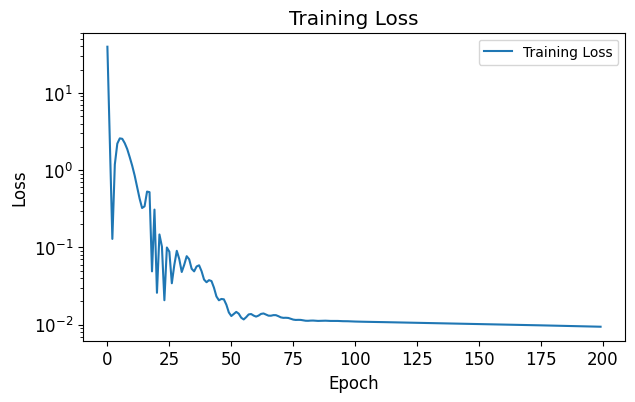

In [37]:
traindata = (u_train, ut_train)
valdata = (u_test, ut_test)
valdata = None

batch_size = 64
num_batches = int(ntraj_train/batch_size)

epochs = 200

# adam w learn rate decay
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                        t < batch_size*(2*num_batches//3),
                        t > batch_size*(2*num_batches//3)],
                        [1e-3, 3e-4, 1e-4]))



trainingdetails,params = train(traindata,valdata, batch_size,num_batches, epochs, verbose =True,batch=True)

Obs: I double pendulum fra LNN artikkel fikk de final loss med 7.3e-2 (LNN) og 7.4e-2 (Baseline) for 600 000 random I.C. 

In [33]:
u_test[0].shape

(101, 4)

In [34]:

ut_pred = jax.vmap(partial(Equation_of_motion, learned_lagrangian(params)))(u_test[0])
ut_pred

Array([[ 0.32039857, -0.2788751 , -0.11552007,  0.06005986],
       [ 0.32033443, -0.2808864 , -0.11398263,  0.05897129],
       [ 0.3201411 , -0.2827824 , -0.11244097,  0.05786809],
       [ 0.3198179 , -0.2845627 , -0.11089697,  0.05675019],
       [ 0.31936428, -0.28622815, -0.10935025,  0.05562045],
       [ 0.31878045, -0.28777814, -0.10780088,  0.0544767 ],
       [ 0.31806606, -0.28921437, -0.10625202,  0.05331902],
       [ 0.31722084, -0.29053593, -0.1047032 ,  0.05215128],
       [ 0.3162459 , -0.29174453, -0.10315177,  0.05097169],
       [ 0.31514177, -0.29284042, -0.10160446,  0.04978534],
       [ 0.31390908, -0.29382405, -0.10005675,  0.04858483],
       [ 0.31254932, -0.29469627, -0.09851225,  0.04737474],
       [ 0.31106374, -0.2954581 , -0.09697089,  0.0461573 ],
       [ 0.3094539 , -0.29611018, -0.09543154,  0.04492706],
       [ 0.30772173, -0.2966528 , -0.09389927,  0.04369288],
       [ 0.3058693 , -0.29708746, -0.09237207,  0.0424457 ],
       [ 0.30389908, -0.

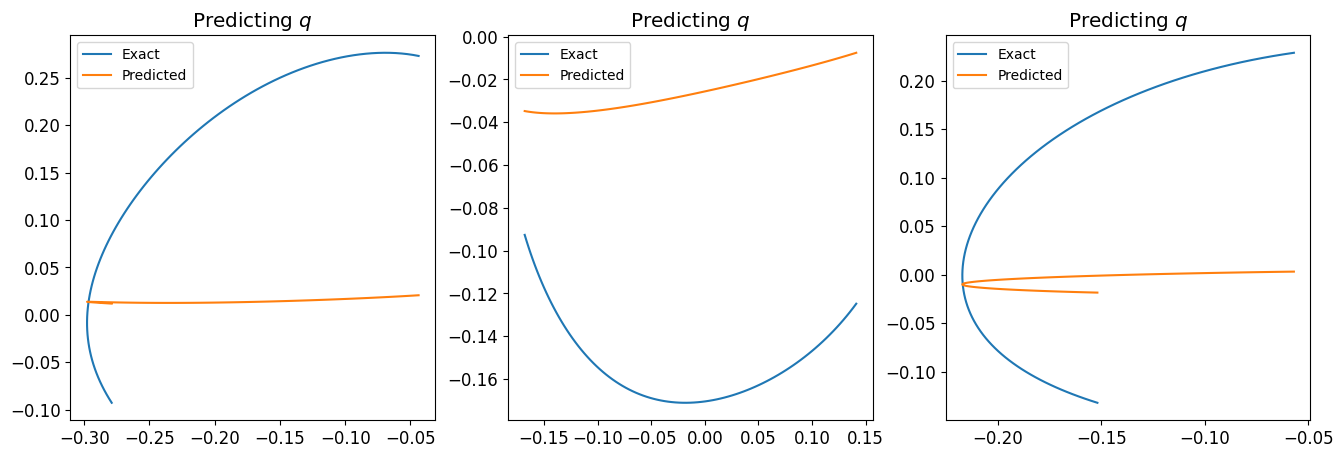

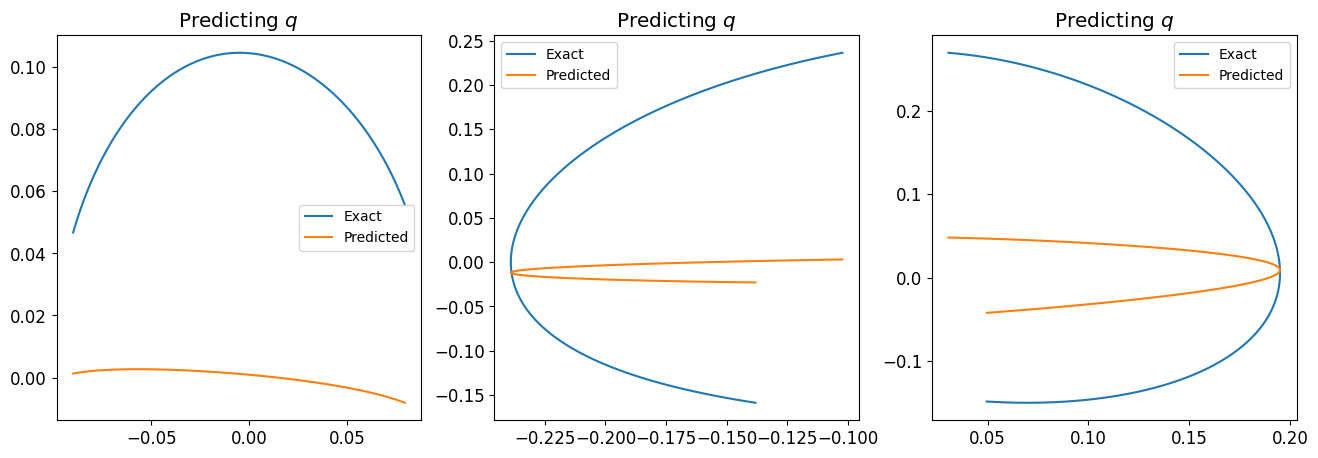

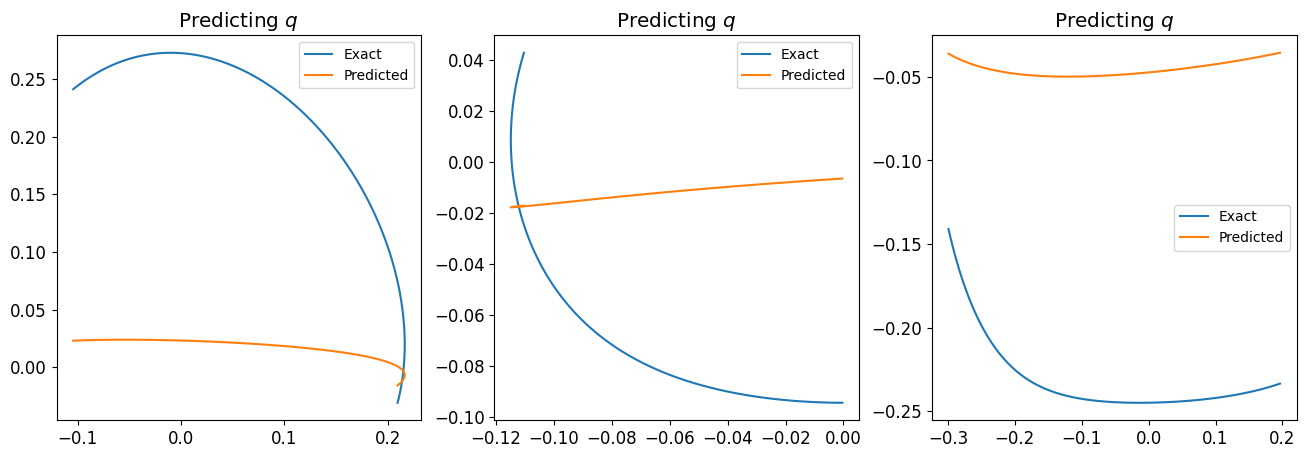

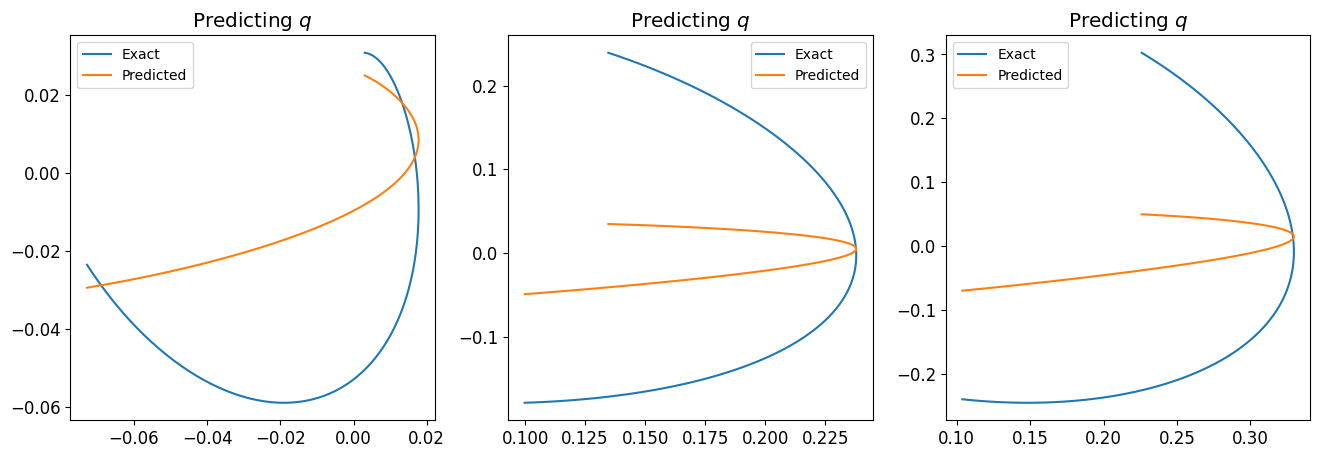

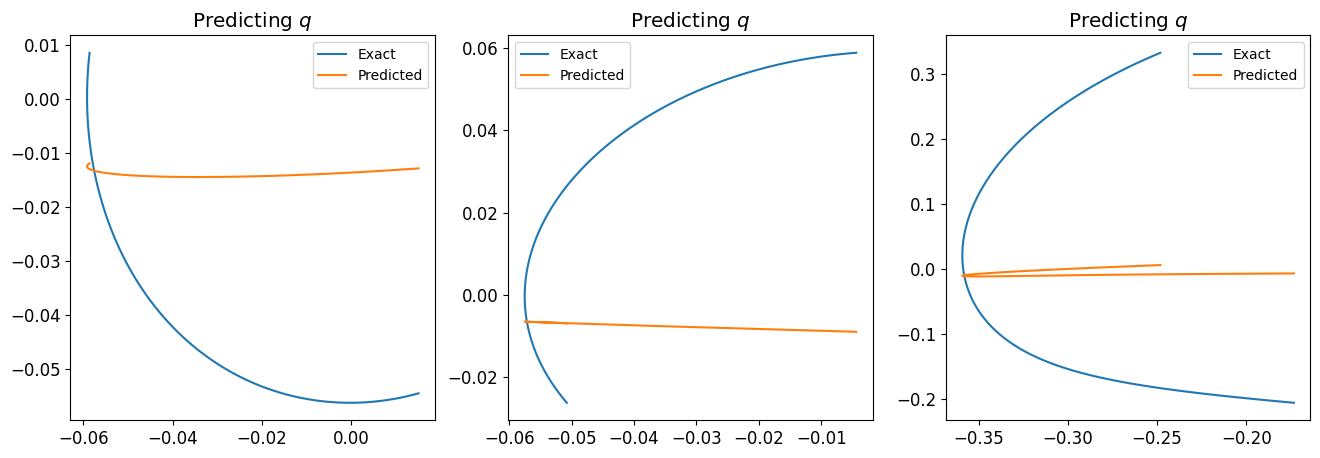

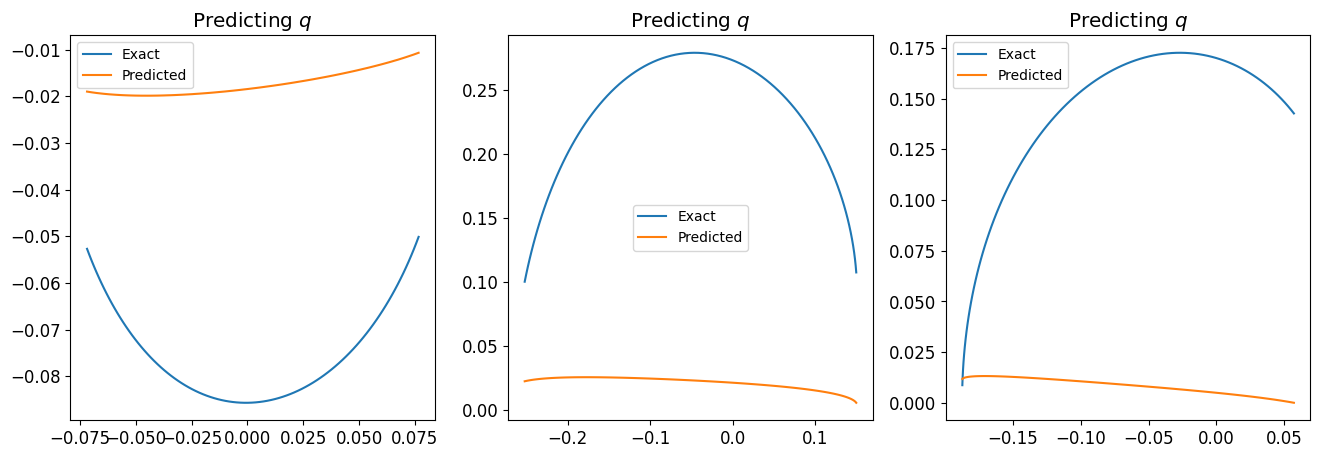

In [38]:
for i in [0,3,6,9,12,15]:

    ut_pred = jax.vmap(partial(Equation_of_motion, learned_lagrangian(params)))(u_test[i])

    fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
    ax[0].plot(ut_test[i][:, 1], ut_test[i][:, 3], label = "Exact")
    ax[0].plot(ut_pred[:, 1], ut_pred[:, 3],label = "Predicted")
    ax[0].legend()
    ax[0].set_title('Predicting $q$')

    ut_pred = jax.vmap(partial(Equation_of_motion, learned_lagrangian(params)))(u_test[i+1])

    
    ax[1].plot(ut_test[i+1][:, 1], ut_test[i+1][:, 3], label = "Exact")
    ax[1].plot(ut_pred[:, 1], ut_pred[:, 3],label = "Predicted")
    ax[1].legend()
    ax[1].set_title('Predicting $q$')

    ut_pred = jax.vmap(partial(Equation_of_motion, learned_lagrangian(params)))(u_test[i+2])

    ax[2].plot(ut_test[i+2][:, 1], ut_test[i+2][:, 3], label = "Exact")
    ax[2].plot(ut_pred[:, 1], ut_pred[:, 3],label = "Predicted")
    ax[2].legend()
    ax[2].set_title('Predicting $q$')



In [36]:
"""
def find_nan(arr):

    # Find indices where NaN values are present
    nan_indices = jnp.where(jnp.isnan(arr))

    # Convert to a list of (i, j, k) index tuples
    nan_indices_list = list(zip(*[arr.tolist() for arr in nan_indices]))

    print(f"Total NaN values found: {len(nan_indices_list)}")
    print(f"Indices of NaN values: {nan_indices_list}")


for arr in [u_train,ut_train,y_train,u_test,ut_test,y_test]:
    find_nan(arr)

i = 0
train_vis = jax.vmap(normalize_dp)(u_train[i])
test_vis = jax.vmap(normalize_dp)(u_test[i])

vel_angle = lambda data:  (np.arctan2(data[:,3], data[:,2]) / np.pi + 1)/2
vel_color = lambda vangle: np.stack( [np.zeros_like(vangle), vangle, 1-vangle]).T
train_colors = vel_color(vel_angle(train_vis))
test_colors = vel_color(vel_angle(test_vis))

# plot
SCALE = 80 ; WIDTH = 0.006
plt.figure(figsize=[8,4], dpi=120)
plt.subplot(1,2,1)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.title("Train data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.quiver(*train_vis.T, color=train_colors, scale=SCALE, width=WIDTH)

plt.subplot(1,2,2)
plt.title("Test data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.quiver(*test_vis.T, color=test_colors, scale=SCALE, width=WIDTH)

plt.tight_layout() ; plt.show()"
"""

'\ndef find_nan(arr):\n\n    # Find indices where NaN values are present\n    nan_indices = jnp.where(jnp.isnan(arr))\n\n    # Convert to a list of (i, j, k) index tuples\n    nan_indices_list = list(zip(*[arr.tolist() for arr in nan_indices]))\n\n    print(f"Total NaN values found: {len(nan_indices_list)}")\n    print(f"Indices of NaN values: {nan_indices_list}")\n\n\nfor arr in [u_train,ut_train,y_train,u_test,ut_test,y_test]:\n    find_nan(arr)\n\ni = 0\ntrain_vis = jax.vmap(normalize_dp)(u_train[i])\ntest_vis = jax.vmap(normalize_dp)(u_test[i])\n\nvel_angle = lambda data:  (np.arctan2(data[:,3], data[:,2]) / np.pi + 1)/2\nvel_color = lambda vangle: np.stack( [np.zeros_like(vangle), vangle, 1-vangle]).T\ntrain_colors = vel_color(vel_angle(train_vis))\ntest_colors = vel_color(vel_angle(test_vis))\n\n# plot\nSCALE = 80 ; WIDTH = 0.006\nplt.figure(figsize=[8,4], dpi=120)\nplt.subplot(1,2,1)\nplt.xlim(-0.5,0.5)\nplt.ylim(-0.5,0.5)\nplt.title("Train data") ; plt.xlabel(r\'$\theta_1$\') ;